In [1]:
import os
#This module provides a portable way of using operating system dependent functionality.
import sys
#This module provides access to some variables used or maintained by the interpreter and
#to functions that interact strongly with the interpreter
sys.path.append('..')

import lzma
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as se
se.set_style('white')
se.set_context('poster')

import pyquery
from ipywidgets import FloatProgress
from IPython.display import display

from config import settings
import utils
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
cases_format="json"
#else "xml"
#cases_format="xml"
compressed_file = utils.get_cases_from_bulk(jurisdiction="New Mexico", data_format=cases_format)

downloading New Mexico-20200302-text.zip into ../data dir


66568it [00:31, 2130.33it/s]


extracting New Mexico-20200302-text.zip into ../data dir
Done.


In [3]:
#a list to hold the cases we're sampling
cases = []

#decompress the file line by line
with lzma.open(compressed_file) as infile:
    for line in infile:
        #decode the file into a convenient format
        record = json.loads(str(line, 'utf-8'))
        #if the decision date on the case matches one we're interested in, add to our list
        cases.append(record)

print("Selected jurisdiction: New Mexico")
print("Number of Cases: ", len(cases))

Selected jurisdiction: New Mexico
Number of Cases:  18338


In [4]:
def parse_json(case):
    feat_dict = {}
    feat_dict["case_id"] = case['id']
    #feat_dict["case_url"] = case['url']
    feat_dict["case_name"] = case['name']
    feat_dict["case_name_abbreviation"] = case['name_abbreviation']
    feat_dict["date"] = case['decision_date']
    feat_dict["year"] = int(case['decision_date'][:4])
    feat_dict["citations"] = [citation for citation in case['citations'] if citation['type'] == 'official'][0]
    #feat_dict["volume"] = case['volume']
    feat_dict["court"] = case['court']['name']
    feat_dict["opinion_count"] = len(case['casebody']['data']['opinions'])
    feat_dict["jurisdiction"] = case['jurisdiction']#['name_long']
    #feat_dict["name"] = case['jurisdiction']['name']
    feat_dict["judges"]=case["casebody"]["data"]["judges"]
    feat_dict["attorneys"]=case["casebody"]["data"]["attorneys"]
    feat_dict["author"]=case["casebody"]["data"]["opinions"][0]["author"]

    #Main text: opinions
    feat_dict["opinion"]=case["casebody"]["data"]["opinions"][0]["text"]

    return feat_dict

In [5]:
#Add progress bar
bar = FloatProgress(min=0, max=len(cases))
display(bar)

#For each file, parse with parse_xml() and add to list of parsed files
parsed_files = []
for case in cases:
    doc = parse_json(case) #json
    #doc = ET_parse_xml(case) #xml
    parsed_files.append(doc)
    bar.value += 1

FloatProgress(value=0.0, max=18338.0)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
raw_df = pd.DataFrame(parsed_files)
raw_df.head()

## Something about the dataset

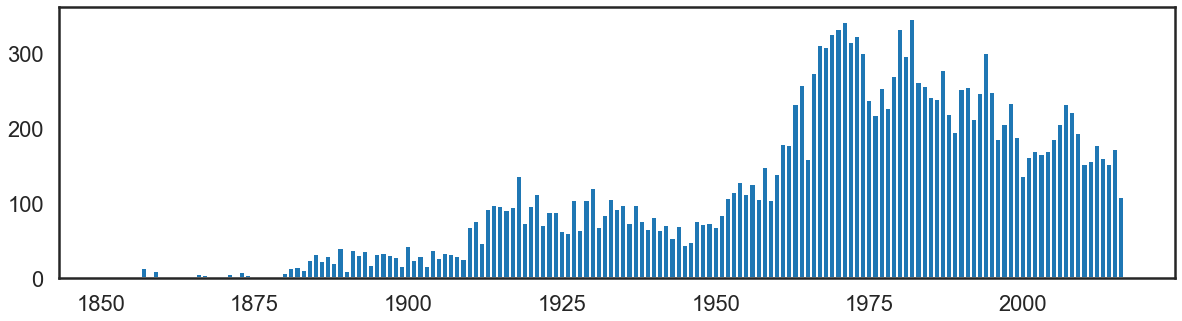

In [7]:
#cases per year
cases_per_year = raw_df['year'].value_counts().sort_index()
years = list(cases_per_year.keys())
values = list(cases_per_year)
 
# creating the bar plot
fig = plt.figure(figsize = (20, 5))
plt.bar(years, values, width = 1)
plt.show()

In [23]:
print("Oldest case in: ", min(raw_df['year']))
print("Most recent case in: ", max(raw_df['year']))

Oldest case in:  1852
Most recent case in:  2016


In [25]:
#opinions per case
print("Number of opinions, number of cases")
raw_df['opinion_count'].value_counts().sort_index()

Number of opinions, number of cases


1    15919
2     2156
3      228
4       32
5        1
6        1
7        1
Name: opinion_count, dtype: int64

Most cases have a single opinion. 

# Something about the authors

In [10]:
#raw_df.head()

In [11]:
#Let's look at how many opinions each author has given
#pd.set_option("display.max_rows", None)
print("Number of authors: ", len(raw_df['author'].value_counts(normalize=False)))
raw_df['author'].value_counts(normalize=False)

Number of authors:  1115


SUTIN, Judge.                                554
WOOD, Chief Judge.                           527
HENDLEY, Judge.                              373
COMPTON, Justice.                            346
WOOD, Judge.                                 339
                                            ... 
BI'CKLEY, Chief Justice.                       1
£INN, Justice.                                 1
BRICE, Justice-                                1
HUDSPETH, Chief Justice, BICKLEY, Justice      1
RobeRts, J.                                    1
Name: author, Length: 1115, dtype: int64

In [12]:
most_prolific_authors = raw_df["author"].value_counts()
print(most_prolific_authors.head(5))

SUTIN, Judge.         554
WOOD, Chief Judge.    527
HENDLEY, Judge.       373
COMPTON, Justice.     346
WOOD, Judge.          339
Name: author, dtype: int64


In [13]:
for justice in most_prolific_authors.index.tolist()[:5]:
    print(justice)

SUTIN, Judge.
WOOD, Chief Judge.
HENDLEY, Judge.
COMPTON, Justice.
WOOD, Judge.


In [14]:
#Filter the dataframe down to entries mentioning Sutin
sutin = raw_df[(raw_df["author"].str.contains('SUTIN', na=False))]

#Let's see how Sutin is listed as an author
sutin["author"].value_counts()[:15]

SUTIN, Judge.                                                  554
SUTIN, Chief Judge.                                             37
SUTIN, J.                                                       12
WOOD, Chief Judge. SUTIN, Judge                                  2
PER CURIAM. HERNANDEZ, Judge. HENDLEY, Judge. SUTIN, Judge.      1
PER CURIAM. SUTIN, Judge                                         1
PER CURIAM: SUTIN, Judge.                                        1
HERNANDEZ, Judge. SUTIN, J., specially concurring.               1
SUTIN, Judge. .                                                  1
PER CURIAM. HERNANDEZ, Judge. SUTIN, Judge. HENDLEY, Judge.      1
'SUTIN, Judge.                                                   1
"SUTIN, Judge.                                                   1
WOOD, Judge. SUTIN, Judge.                                       1
STOWERS, Justice. SUTIN, Judge.                                  1
SUTIN, Judge                                                  

In [15]:
#Clean entries up a little bit
aliases_justice = ["SUTIN, Chief Judge.", "SUTIN, Judge.", "SUTIN, J.", "SUTIN, Judge. .", "'SUTIN, Judge.", '"SUTIN, Judge.',"SUTIN, Judge"]

sutin = sutin.replace(aliases_justice, "SUTIN, Judge.")

In [16]:
sutin["author"].value_counts()

SUTIN, Judge.                                                  607
WOOD, Chief Judge. SUTIN, Judge                                  2
SUTIN, Judge. PICKARD, Judge                                     1
PER CURIAM. HERNANDEZ, Judge. HENDLEY, Judge. SUTIN, Judge.      1
PER CURIAM. SUTIN, Judge                                         1
PER CURIAM: SUTIN, Judge.                                        1
HERNANDEZ, Judge. SUTIN, J., specially concurring.               1
PER CURIAM. HERNANDEZ, Judge. SUTIN, Judge. HENDLEY, Judge.      1
WOOD, Judge. SUTIN, Judge.                                       1
STOWERS, Justice. SUTIN, Judge.                                  1
PER CURIAM. SUTIN, Judge.                                        1
SUTIN, Judge. WOOD, J., specially concurring.                    1
SUTIN, Judge. WALTERS, Judge                                     1
JONATHAN B. SUTIN, Judge.                                        1
SUTIN, Judge. SUTIN, Judge:                                   

# Courts

In [17]:
#How many cases fall in each court
raw_df['court'].value_counts(normalize=False)

Supreme Court of New Mexico       11442
Court of Appeals of New Mexico     6896
Name: court, dtype: int64

In [18]:
#Average word count for a case opinion in New Mexico 
sum_words = 0
num_cases = 0
for opinion in raw_df['opinion']: 
    sum_words += len(opinion.split())
    num_cases += 1
    
avg_words = sum_words//num_cases
print(f"Average word count for a case opinion in New Mexico: {avg_words}")

Average word count for a case opinion in New Mexico: 2477


In [19]:
#Average word count for each court
court_len = []

#Build a list of tuples indicating average lengths for each court
for court in raw_df["court"].unique():
    num_cases = raw_df[raw_df["court"] == court].shape[0]
    sum_words=0
    for opinion in raw_df[raw_df["court"] == court]["opinion"]:
        sum_words += len(opinion.split())
    court_len.append((court, sum_words//num_cases))

#Sort by average length
court_len = sorted(court_len, key=lambda x: x[1])

print(f"\033[1mCases for court:\033[0m")
print(raw_df['court'].value_counts())
print()
print(f"\033[1mAverage word count for each court:\033[0m")
print(court_len)

Cases for court:
Supreme Court of New Mexico       11442
Court of Appeals of New Mexico     6896
Name: court, dtype: int64

Average word count for each court:
[('Supreme Court of New Mexico', 2232), ('Court of Appeals of New Mexico', 2882)]


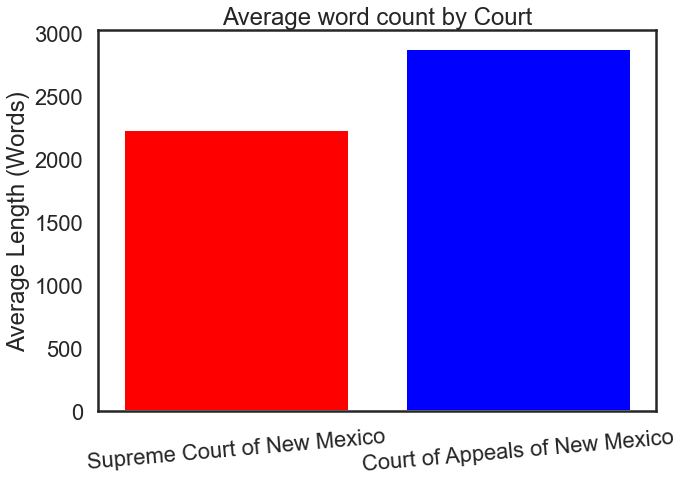

In [20]:
#Display bar plot of lengths
court_color_dict = {
    'Supreme Court of New Mexico': 'red',
    'Court of Appeals of New Mexico': 'blue'
}

plt.figure(figsize=(10,7))
for i, court in enumerate(court_len):
    plt.bar(i, court[1], color=court_color_dict[court[0]])

plt.title("Average word count by Court")
#plt.xlabel("Court")
plt.ylabel("Average Length (Words)")
plt.xticks(list(range(0,len(court_len))), [x[0] for x in court_len])
locations, labels = plt.xticks()
plt.setp(labels, rotation=5)

plt.show()

## Unigrams

In [21]:
#Loop through cases and build rows with case metadata AND opinion metadata/text.
#We load in all of the keys initially, then modify the ones we want to.

opinion_data = []
for case in cases:
    for opinion in case["casebody"]["data"]["opinions"]:
        temp = {}
        keys = list(case.keys())
        keys.remove('casebody')
        for key in keys:         
            temp[key] = case[key]
        keys = list(opinion.keys())
        for key in keys:         
            temp[key] = opinion[key]
        opinion_data.append(temp)

opinions_df = pd.DataFrame(opinion_data)
opinions_df["citations"] = opinions_df["citations"].apply(lambda x:x[0]['cite'])
opinions_df["court"] = opinions_df["court"].apply(lambda x:x['name'])
opinions_df["decision_date"] = opinions_df["decision_date"].apply(lambda x:int(x[:4]))
opinions_df = opinions_df.drop(["docket_number", "first_page", 
                                "last_page", "name_abbreviation",
                                "reporter", "volume", "jurisdiction"], axis=1)
opinions_df = opinions_df[["id", "name", "decision_date", "court", "citations", "author", "type", "text"]]

opinions_df.head()

,id,name,decision_date,court,citations,author,type,text
0,17491,"STATE of New Mexico, Plaintiff-Appellee, v. Lo...",1997,Supreme Court of New Mexico,124 N.M. 388,"MINZNER, Justice.",majority,"OPINION\nMINZNER, Justice.\n(1)Defendant Lonni..."
1,17129,"STATE of New Mexico, ex rel. CHILDREN, YOUTH A...",1998,Court of Appeals of New Mexico,124 N.M. 735,"WECHSLER, Judge.",majority,"OPINION\nWECHSLER, Judge.\n1. As a result of a..."
2,18630,"Caye C. BUCKINGHAM, Plaintiff-Appellant, v. Ja...",1997,Court of Appeals of New Mexico,124 N.M. 498,"PICKARD, Judge.",majority,"OPINION\nPICKARD, Judge.\n¶ 1 This case requir..."
3,18319,"STATE of New Mexico ex rel. Alan E. WHITEHEAD,...",1997,Court of Appeals of New Mexico,124 N.M. 375,"BOSSON, Judge.",majority,"OPINION\nBOSSON, Judge.\n1. Article II, Sectio..."
4,17318,"STATE of New Mexico, Plaintiff-Appellee, v. Sa...",1997,Court of Appeals of New Mexico,124 N.M. 211,"PICKARD, Judge.",majority,"OPINION\nPICKARD, Judge.\n1. Defendant appeals..."


There is a total of 48447582 words.
The term Telephone occurs 3573 times.
The term Computer occurs 1704 times.
The term Robbery occurs 3110 times.
The term Evidence occurs 135891 times.


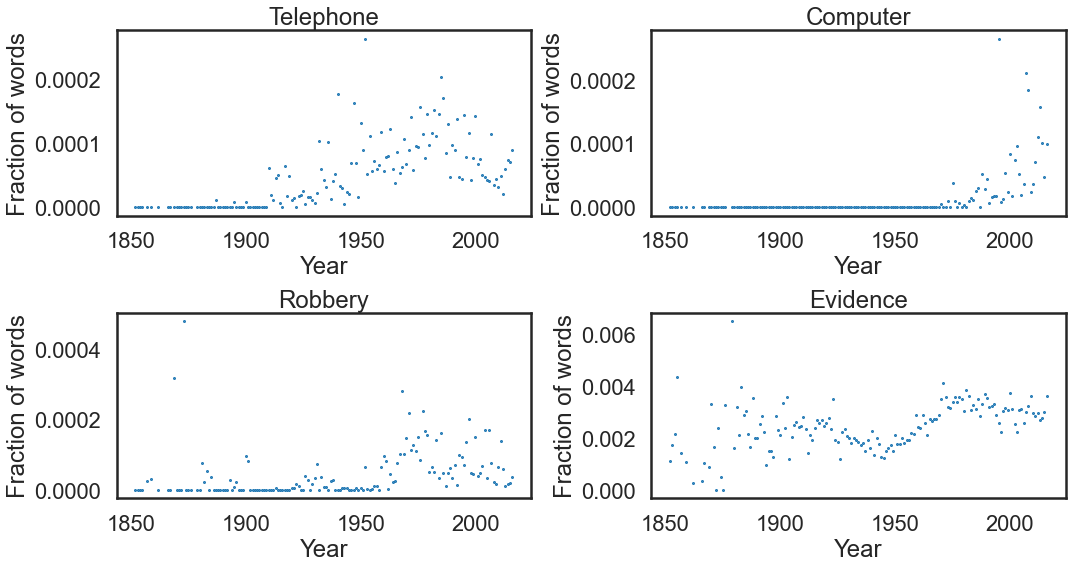

In [22]:
def search_ngram(ngram):
    pairs = []
    tot = 0
    n_tot = 0
    for year in opinions_df["decision_date"].unique():
        temp = opinions_df[opinions_df["decision_date"] == year]["text"].tolist()
        temp = " ".join(temp).lower()
        n = len(temp.split(" "))
        ngram_count = temp.count(ngram.lower())
        pairs.append((year, ngram_count/n))
        tot += ngram_count
        n_tot += n
    return pairs, tot, n_tot

def graph_ngram(pairs, ax, title):
    x,y = [list(x) for x in zip(*pairs)]
    ax.scatter(x,y, s=1)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Fraction of words")
    return ax


fig, axes = plt.subplots(2, 2, figsize=(15,8))
word1 = search_ngram("telephone")
word2 = search_ngram("computer")
word3 = search_ngram("robbery")
word4 = search_ngram("evidence")
#word5 = search_ngram("opinion")
#word6 = search_ngram("cowboy")

graph_ngram(word1[0], axes[0,0], "Telephone")
graph_ngram(word2[0], axes[0,1], "Computer")
graph_ngram(word3[0], axes[1,0], "Robbery")
graph_ngram(word4[0], axes[1,1], "Evidence")
#graph_ngram(word5[0], axes[2,0], "Opinion")
#graph_ngram(word6[0], axes[2,1], "Cowboy")

print(f'There is a total of {word2[2]} words.')
print(f'The term Telephone occurs {word1[1]} times.')
print(f'The term Computer occurs {word2[1]} times.')
print(f'The term Robbery occurs {word3[1]} times.')
print(f'The term Evidence occurs {word4[1]} times.')
#print(f'The term Sheriff occurs {word5[1]} times.')
#print(f'The term Cowboy occurs {word6[1]} times.')


plt.tight_layout()
plt.show()